# 1. Configuration

In [81]:
import pandas as pd
import altair as alt
import joblib
from io import BytesIO
import os
import sys

# Add project root (one level up from notebooks/) to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# ---- FUNCTIONS ----

from src.extract_usage import extract_usage
from src.necessity_index import compute_necessity, index_scaler, qcut_labels
from src.column_detection import detect_freeform_col
from src.shortlist import shortlist_applications
from src.twinkl_originals import find_book_candidates
from src.preprocess_text import normalise_text 
from typing import Tuple

pd.set_option('display.max_colwidth', 500)

In [2]:
def load_heartfelt_predictor():
    # Compute absolute path from notebook location
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    model_path = os.path.join(project_root, "src", "models", "heartfelt_pipeline.joblib")
    return joblib.load(model_path)


In [3]:
def load_and_process(raw_csv) -> Tuple[pd.DataFrame, str]:
    """
    Load CSV from raw bytes, detect freeform column, compute necessity scores,
    and extract usage items. Returns processed DataFrame and freeform column name.
    """
    # Read Uploaded Data 
    df_orig = pd.read_csv(raw_csv)

    # Detect freeform column
    freeform_col = detect_freeform_col(df_orig)

    df_orig = df_orig[df_orig[freeform_col].notna()]

    #Word Count
    df_orig['word_count'] = df_orig[freeform_col].fillna('').str.split().str.len()

    # Compute Necessity Scores
    scored = df_orig.join(df_orig[freeform_col].apply(compute_necessity))
    scored['necessity_index'] = index_scaler(scored['necessity_index'].values)
    scored['priority'] = qcut_labels(scored['necessity_index'])

    # Find Twinkl Originals Candidates
    scored['book_candidates'] = find_book_candidates(scored, freeform_col)

    # Label Heartfelt Applications
    scored['clean_text'] = scored[freeform_col].map(normalise_text)
    model = load_heartfelt_predictor()
    scored['is_heartfelt'] = model.predict(scored['clean_text'].astype(str))


    
    # Usage Extraction
    #docs = df_orig[freeform_col].to_list()  <---- Disabled Ai-powered extraction for testing
    #scored['Usage'] = extract_usage(docs)

    return scored, freeform_col



In [4]:
df, freeform_col = load_and_process('data/feb-march-data.csv')

/Users/lynn/Documents/Twinkl/grant-applications-app/src/twinkl_originals.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_primary = series.str.contains(pattern_level, case=False, na=False)


In [5]:
df.columns

Index(['Id', 'Date/Time Requested', 'Giveaway Title', 'Customer Name',
       'Email Address', 'School Name', 'Postal Address', 'Address Line 2',
       'Address City', 'Postcode', 'Additional Info', 'Unnamed: 11',
       'word_count', 'necessity_index', 'urgency_score', 'severity_score',
       'vulnerability_score', 'priority', 'book_candidates', 'clean_text',
       'is_heartfelt'],
      dtype='object')

In [6]:
df[[freeform_col, 'necessity_index']].head(3)

,Additional Info,necessity_index
0,I would love to use it to spread the love of reading for pleasure by being about to provide an outdoor library for all pupils to be able to enjoy at all times of the day but especially during their break times. Having continual accept to good quality book to be read at least is the key to developing a love to reading that could last a life time.,0.25000
1,We would like to introduce early years yoga and mindfulness classes to the children using interactive storytelling adventures fused with yoga postures. We would like to purchase a range of props to bring more fun and magic to the classes and this grant would support this,0.06250
2,"Â£500 would enable us to set up a small sensory room for the teenagers we work with. They are out of school due to their mental health but those who are well enough to leave their homes are starting to come to our community house for 1:1 academic or life skills sessions. We've furnished it with donations from Facebook groups so it looks like a home but the small room that has sensory room potential needs beanbags, lighting and sensory equipment so it can be used.",0.09375


# 2. Topic Modeling Testing

## 2.1 Configuration

In [14]:
import importlib
import src.models.topicModeling_contentRequests as tmc

importlib.reload(tmc)

# Use functions like this:
embedding_model = tmc.load_embedding_model('all-MiniLM-L12-v2')

Using device: mps


In [15]:
import spacy
from spacy.cli import download
import importlib.util

def load_spacy_model(model_name="en_core_web_md"):
    if importlib.util.find_spec(model_name) is None:
        print(f"Model '{model_name}' not found. Downloading now...")
        download(model_name)
    return spacy.load(model_name)


In [16]:
nlp = load_spacy_model(model_name='en_core_web_md')

## 2.2 Preprocessing

In [17]:
def spacy_sent_tokenize(text):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [18]:
sentences = []
mapping = []

for idx, response in df[freeform_col].dropna().items():
    for sentence in spacy_sent_tokenize(response):
        sentences.append(sentence)
        mapping.append(idx)

In [19]:
print(f"Total sentences: {len(sentences)}")
print(f"Total mappings: {len(mapping)}")

Total sentences: 3370
Total mappings: 3370


In [23]:
embeddings = tmc.encode_content_documents(embedding_model, sentences)

Encoding Batches: 100%|████████████████████████████████████████████| 169/169 [00:07<00:00, 21.91it/s]


## 2.3 Topic Modeling and Labeling

In [24]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [76]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech, OpenAI
import openai
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords = list(nlp.Defaults.stop_words)


custom_stopwords = [
    'thank you', 'thankyou', 'thanks', 'thank'
    'children', 'child', 'students',
    'twinkl',
    'funding'
    
]

stopwords.extend(custom_stopwords)

vectorizer_model = CountVectorizer(stop_words=stopwords, ngram_range=(1,2))


topic_model = BERTopic(
    verbose=True,
    umap_model=umap_model,
    representation_model=KeyBERTInspired(),
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    nr_topics='auto'
)
topics, probs = topic_model.fit_transform(sentences, embeddings)

2025-05-23 12:44:58,162 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-23 12:45:03,983 - BERTopic - Dimensionality - Completed ✓
2025-05-23 12:45:03,983 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 12:45:04,031 - BERTopic - Cluster - Completed ✓
2025-05-23 12:45:04,032 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-23 12:45:04,098 - BERTopic - Representation - Completed ✓
2025-05-23 12:45:04,099 - BERTopic - Topic reduction - Reducing number of topics
2025-05-23 12:45:04,104 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 12:45:05,230 - BERTopic - Representation - Completed ✓
2025-05-23 12:45:05,231 - BERTopic - Topic reduction - Reduced number of topics from 72 to 33


In [77]:
pd.set_option('display.max_rows', None)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1279,-1_buy resources_support children_resources_educational,"[buy resources, support children, resources, educational, develop, supplies, education, development, funds, learners]","[We would use this money to buy resources that help develop the children's literacy and numeracy skills, especially in our outdoor environment., I would like to buy equipment and resources to help develop theses skills and help to support these children to develop in order for them to thrive in the future., Buy resources to support learning]"
1,0,1271,0_support children_money_funds_use money,"[support children, money, funds, use money, educational, benefit, money buy, education, develop, children]","[We would use this money to buy sensory equipment for our Nurture provision., We would use any money to support our children in developing their outdoor space., We have a high number of pupils in foundation phase with additional sensory needs, we would use the money to get resources to support these pupils]"
2,1,153,1_sensory garden_garden children_garden_gardening,"[sensory garden, garden children, garden, gardening, garden school, making sensory, gardening equipment, gardening tools, create sensory, planting]","[Our Japanese garden needs transforming into a sensory garden for our children with SEN., We would very much like to make a sensory garden for the children to enjoy!, We would love some plants to create a sensory garden for the under 2's.]"
3,2,54,2_charity preschool_preschool_nursery_new nursery,"[charity preschool, preschool, nursery, new nursery, nursery setting, run preschool, reception nursery, infant school, nursery september, small charity]","[Our charity preschool, proudly serving the community for over 40 years, is dedicated to providing a safe, nurturing, and inspiring environment for young children to learn, grow, and thrive., We are a small charity run community nursery in Elsecar, Barnsley., We are a small charity run preschool in a small village in Somerset, we only have 17 children on the register (which is quite busy for us!)]"
4,3,53,3_science develop_making science_future scientists_scientists,"[science develop, making science, future scientists, scientists, scientists ensure, investigations encourage, scientific, new science, science, practical science]","[This funding would bring science to life fostering curiosity, creativity and problem solving skills through real world nature based learning., Your funding would ensure all our pupils, regardless of background, can experience the excitement of real-world science and develop a lifelong love for STEM with some extra funding., Your funding would ensure all our pupils, regardless of background, can experience the excitement of real-world science and develop a lifelong love for STEM with some ex..."
5,4,43,4_pencils equipment_crafts_art supplies_pencils craft,"[pencils equipment, crafts, art supplies, pencils craft, supplies, glue sticks, pencils, pens pencils, craft materials, notebooks pencils]","[Then with any left over money I would buy basic supplies like glue sticks, paper, coloured paper, pens and pencils, as money is very tight!, Aswell as stationery like glue sticks, pens, pencils and colouring pencils\nAlso equipment to help to support SEND children with motor skills!, Aswell as stationery like glue sticks, pens, pencils and colouring pencils\nAlso equipment to help to support SEND children with motor skills!]"
6,5,32,5_money gratefully_receive gratefully_money greatly_money monumental,"[money gratefully, receive gratefully, money greatly, money monumental, money receive, priorities money, opportunity money, years fund, delighted obtain, impact funds]","[Any money we receive will be very gratefully received., The money would be so gratefully received and have a big impact., We would dearly love to update our history artefacts and our globes and atlases to help enrich our history and geography lessons.]"
7,6,32,6

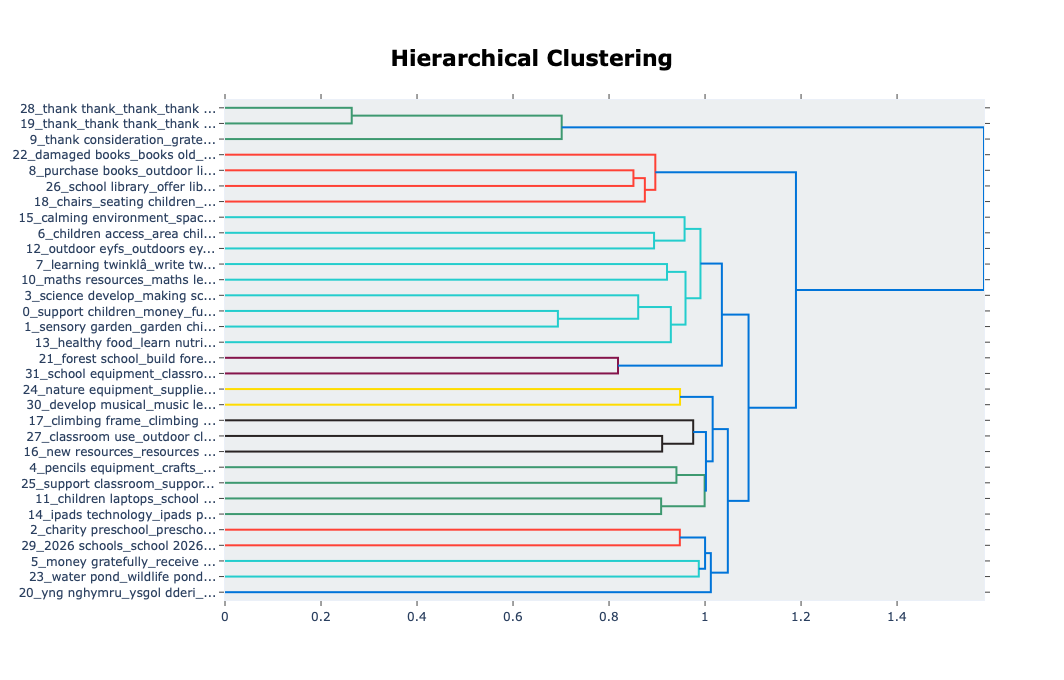

In [78]:
topic_model.visualize_hierarchy()

In [87]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)
prompt = """
This topic contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short yet descriptive topic label.
"""
openai_model = OpenAI(
    client,
    model="gpt-4.1-nano",
    exponential_backoff=True,
    chat=True,
    prompt=prompt,
    system_prompt=
    """
**Task**: As a topic modeling expert, your responsibility is to generate concise yet comprehensive topic labels from rows in a BertTopic `topic_info` dataframe. These topics have been derived from grant application forms submitted by schools, tutors, or other institutions participating in Twinkl giveaways.

**Objective**: Your goal is to create labels for the extracted topics that accurately and clearly describe each topic within the specified context. These labels should be easily interpretable by the members of the Community Collections team.

**Instructions**:

1. **Understand the Context**: The topics relate to grant applications and are relevant to educational institutions participating in Twinkl giveaways.

2. **Generate Labels**:
    - Create labels that are short yet capture the essence of each topic.
    - Ensure that the labels are contextually appropriate and provide clarity.
    - Focus on making the labels easily understandable for the Community Collections team.

3. **Considerations**:
    - Each label should succinctly convey the main idea of the topic.
    - Avoid overly technical language unless necessary for precision.
    - Ensure the labels align with the overall educational and grant-related context.
    """
)
    

representation_model = {
    "Main": KeyBERTInspired(),
    "Secondary Representation": MaximalMarginalRelevance(diversity=0.3),
    "OpenAI": openai_model
}

vectorizer_model = CountVectorizer(ngram_range=(1,2))

topic_model.update_topics(sentences, representation_model=representation_model, vectorizer_model=vectorizer_model)

100%|████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


In [88]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Secondary Representation,OpenAI,Representative_Docs
0,-1,1279,-1_children_children to_funding_the children,"[children, children to, funding, the children, our children, provision, money, provide, our school, resources]","[to, our, for, children, are, school, resources, support, we would, students]",[Early Childhood Learning Resources and Sensory Areas],"[We would use this money to buy resources that help develop the children's literacy and numeracy skills, especially in our outdoor environment., I would like to buy equipment and resources to help develop theses skills and help to support these children to develop in order for them to thrive in the future., Buy resources to support learning]"
1,0,1271,0_funding_resources to_money_develop,"[funding, resources to, money, develop, resources, money to, our school, the money, we would, our children]","[our, children, for, school, sensory, support, resources, we would, be, needs]",[Outdoor and Sensory Learning Resources for Children],"[We would use this money to buy sensory equipment for our Nurture provision., We would use any money to support our children in developing their outdoor space., We have a high number of pupils in foundation phase with additional sensory needs, we would use the money to get resources to support these pupils]"
2,1,153,1_sensory garden_garden for_garden_gardening,"[sensory garden, garden for, garden, gardening, our garden, garden and, the garden, planting, plants, plants and]","[garden, plants, sensory garden, grow, garden for, gardening, planters, seeds, kitchen, vegetables]",[Sensory Garden and Outdoor Play Development],"[Our Japanese garden needs transforming into a sensory garden for our children with SEN., We would very much like to make a sensory garden for the children to enjoy!, We would love some plants to create a sensory garden for the under 2's.]"
3,2,54,2_our nursery_nursery setting_nursery_new nursery,"[our nursery, nursery setting, nursery, new nursery, nursery in, charity preschool, nursery and, the nursery, preschool, preschool in]","[nursery, we are, are, preschool, are small, our, nursery in, our nursery, children aged, small charity]",[Small Charity and Community Nurseries in Somerset and Barnsley],"[Our charity preschool, proudly serving the community for over 40 years, is dedicated to providing a safe, nurturing, and inspiring environment for young children to learn, grow, and thrive., We are a small charity run community nursery in Elsecar, Barnsley., We are a small charity run preschool in a small village in Somerset, we only have 17 children on the register (which is quite busy for us!)]"
4,3,53,3_funding would_funding_this funding_scientists,"[funding would, funding, this funding, scientists, science experiences, science and, scientific, and science, science, for stem]","[science, stem, funding, funding would, this funding, problem solving, real world, develop, investigations, science equipment]",[STEM Education and Science Funding],"[This funding would bring science to life fostering curiosity, creativity and problem solving skills through real world nature based learning., Your funding would ensure all our pupils, regardless of background, can experience the excitement of real-world science and develop a lifelong love for STEM with some extra funding., Your funding would ensure all our pupils, regardless of background, can experience the excitement of real-world science and develop a lifelong love for STEM with some ex..."
5,4,43,4_pencils also_and pencils_crafts_pencils and,"[pencils also, and pencils, crafts, pencils and, art supplies, pencils, glue sticks, pens pencils, supplies, and craft]","[glue, pencils, glue sticks, pens pencils, paper, stationery, supplies, pencils and, craft materials, sticks pens]",[Art Supplies and Educational Materials],"[Then with any left over money I would buy basic supplies like glue sticks, paper, coloured paper, pens and pencils, as money is very tight!, Aswell